# Correct the data folder

In [4]:
import os
import shutil
import random

# Define paths to lion and cheetah datasets
parent_dir = '/kaggle/input/sentiment-analysis-dataset/Sentiment classifier/'
happy_dataset_dir = parent_dir + 'happy'
sad_dataset_dir = parent_dir + 'sad'

# Define paths for train, test, and validation directories
train_dir = './working/train/'
test_dir = './working/test'
val_dir = './working/validation'

# Create train, test, and validation directories if they don't exist
os.makedirs("./working", exist_ok=True)
os.makedirs(train_dir, exist_ok=True)
os.makedirs(test_dir, exist_ok=True)
os.makedirs(val_dir, exist_ok=True)


os.makedirs(train_dir+ '/happy', exist_ok=True)
os.makedirs(test_dir + '/happy', exist_ok=True)
os.makedirs(val_dir + '/happy', exist_ok=True)

os.makedirs(train_dir+ '/sad', exist_ok=True)
os.makedirs(test_dir + '/sad', exist_ok=True)
os.makedirs(val_dir + '/sad', exist_ok=True)


# Function to move files to respective directories
def split_dataset(dataset_dir, train_dir, test_dir, val_dir, split_ratio=(0.8, 0.1, 0.1)):
    files = os.listdir(dataset_dir)
    random.shuffle(files)

    # Calculate split sizes
    train_size = int(split_ratio[0] * len(files))
    test_size = int(split_ratio[1] * len(files))
    val_size = len(files) - train_size - test_size

    # Move files to train directory
    for file in files[:train_size]:
        shutil.copy(os.path.join(dataset_dir, file), os.path.join(train_dir, file))

    # Move files to test directory
    for file in files[train_size:train_size+test_size]:
        shutil.copy(os.path.join(dataset_dir, file), os.path.join(test_dir, file))

    # Move files to validation directory
    for file in files[train_size+test_size:]:
        shutil.copy(os.path.join(dataset_dir, file), os.path.join(val_dir, file))

# Split lion dataset
split_dataset(happy_dataset_dir, os.path.join(train_dir, 'happy'), os.path.join(test_dir, 'happy'), os.path.join(val_dir, 'happy'))

# Split cheetah dataset
split_dataset(sad_dataset_dir, os.path.join(train_dir, 'sad'), os.path.join(test_dir, 'sad'), os.path.join(val_dir, 'sad'))

print("Dataset split completed.")


Dataset split completed.


# Image Sentiment Analysis
## ** USING self built VGG and RESNET50 **
## Import required labraries
The below code sets up the environment for training neural network models using PyTorch in a Jupyter Notebook. It includes:

- Importing necessary libraries and enabling compatibility for Python 2.x and 3.x.
- Checking GPU availability.
- Activating interactive mode for matplotlib.
- Importing modules for model training, data handling, and utility tasks.
- Notifying CUDA GPU usage if available.


In [5]:
from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.autograd import Variable
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy
from tqdm import tqdm


plt.ion()

use_gpu = torch.cuda.is_available()
if use_gpu:
    print("Using CUDA")

## Data loading and preprocessing

### 1. Data Directory Setup:
   - Defines the directory paths for the dataset. The original data directory is commented out, and a new directory path is set to "/kaggle/working/".

### 2. Dataset Transformation Setup:
   - Defines transformation pipelines for the training, validation, and test datasets using `transforms.Compose`. This includes resizing images to 256x256, center cropping to 224x224, and converting images to tensors.

### 3. Image Dataset Loading:
   - Loads image datasets using `datasets.ImageFolder` for training, validation, and test sets. The `transform` parameter is set to apply the corresponding transformations defined earlier.

### 4. DataLoader Setup:
   - Sets up data loaders using `torch.utils.data.DataLoader` for efficient data handling during training, validation, and testing. Each DataLoader is configured with a batch size of 32, shuffling, and 4 worker processes for parallel data loading.

### 5. Dataset Sizes and Classes:
   - Computes and prints the number of images loaded for each dataset (training, validation, and test).
   - Prints the classes (categories) of the images in the training dataset.



In [6]:
data_dir = "./working/"
TRAIN = 'train'
VAL = 'validation'
TEST = 'test'
batch_size=32

data_transforms = {
    TRAIN: transforms.Compose([
          transforms.Grayscale(),
          transforms.Resize(256),
          transforms.CenterCrop(224),
        transforms.ToTensor(),
    ]),
    VAL: transforms.Compose([
        transforms.Grayscale(),
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
    ]),
    TEST: transforms.Compose([
        transforms.Grayscale(),
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
    ])
}

image_datasets = {
    x: datasets.ImageFolder(
        os.path.join(data_dir, x),
        transform=data_transforms[x]
    )
    for x in [TRAIN, VAL, TEST]
}

dataloaders = {
    x: torch.utils.data.DataLoader(
        image_datasets[x], batch_size=32,
        shuffle=True, num_workers=4
    )
    for x in [TRAIN, VAL, TEST]
}

dataset_sizes = {x: len(image_datasets[x]) for x in [TRAIN, VAL, TEST]}

for x in [TRAIN, VAL, TEST]:
    print("Loaded {} images under {}".format(dataset_sizes[x], x))

print("Classes: ")
class_names = image_datasets[TRAIN].classes
print(image_datasets[TRAIN].classes)


Loaded 1077 images under train
Loaded 137 images under validation
Loaded 133 images under test
Classes: 
['happy', 'sad']


# Util Functions and Data Visualization

1. **imshow Function:**
   - `imshow(inp, title=None)`: This function takes a tensor `inp` as input, converts it to a NumPy array, and transposes its dimensions to (height, width, channels). It then plots the image using matplotlib with an optional `title`. The figure size is set to (10, 10), and the axis is turned off for better visualization.

2. **show_databatch Function:**
   - `show_databatch(inputs, classes)`: This function creates a grid of images from the input tensor `inputs` using `torchvision.utils.make_grid`. It then calls `imshow` to visualize the grid of images along with their corresponding `classes`.

3. **Visualization of Training Data Batch:**
   - `inputs, classes = next(iter(dataloaders[TRAIN]))`: Retrieves the next batch of data from the training dataloader. `inputs` contains the input data of the batch, and `classes` contains the corresponding class labels for the images in the batch.
   
   - `show_databatch(inputs, classes)`: Calls the `show_databatch` function to visualize the batch of training data.

By running this code, a grid of images from the batch of training data along with their corresponding class labels will be displayed.


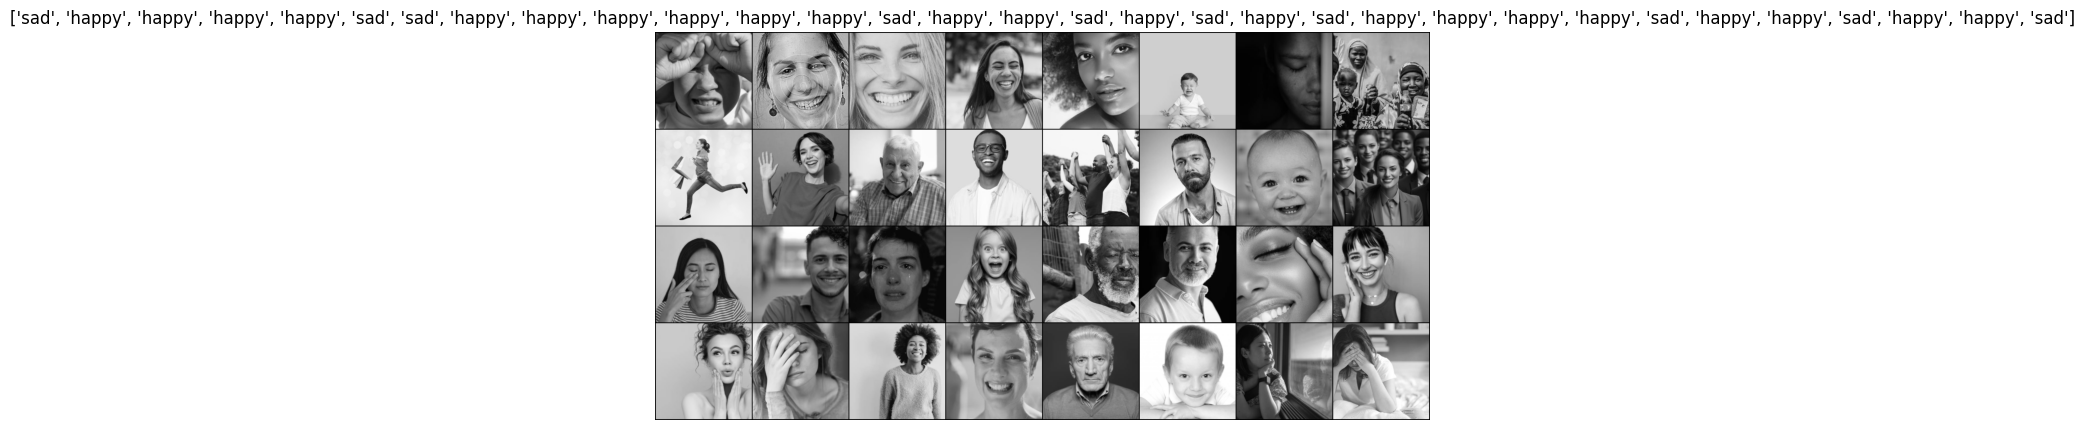

In [7]:
def imshow(inp, title=None):
    inp = inp.numpy().transpose((1, 2, 0))
    plt.figure(figsize=(10, 10))
    plt.axis('off')
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)

def show_databatch(inputs, classes):
    out = torchvision.utils.make_grid(inputs)
    imshow(out, title=[class_names[x] for x in classes])

# Get a batch of training data
inputs, classes = next(iter(dataloaders[TRAIN]))
show_databatch(inputs, classes)

#Model Visualization class

1. **visualize_model Function:**
   - `visualize_model(model, num_images=6)`: This function takes a neural network model `model` and an optional argument `num_images` (default is 6) specifying the number of images to visualize.

   - Initialization:
     - `was_training = model.training`: Stores the original training state of the model.

   - Set Model for Evaluation:
     - `model.train(False)`: Sets the model to evaluation mode.
     - `model.eval()`: Calls the `eval()` method to switch the model to evaluation mode.

   - Iterating Through Test Data:
     - Iterates through the test dataloader.
     - Retrieves input images and their corresponding labels.
     - Converts inputs and labels to PyTorch Variables, with GPU acceleration if available.
     - Passes inputs through the model to obtain outputs.
     - Computes predicted labels using the model's outputs.
     - Prints the ground truth labels and predicted labels for each batch of images.

   - Memory Management:
     - Clears variables and releases GPU memory to avoid memory overflow.

   - Reverting Model State:
     - `model.train(mode=was_training)`: Reverts the model back to its original training state (if it was in training mode before visualization).

By running this function with a neural network model, you can visualize the model's predictions on a subset of test data.


In [8]:
def visualize_model(model, num_images=6):
    was_training = model.training

    # Set model for evaluation
    model.train(False)
    model.eval()

    images_so_far = 0

    for i, data in enumerate(dataloaders[TEST]):
        inputs, labels = data
        size = inputs.size()[0]

        if use_gpu:
            inputs, labels = Variable(inputs.cuda(), volatile=True), Variable(labels.cuda(), volatile=True)
        else:
            inputs, labels = Variable(inputs, volatile=True), Variable(labels, volatile=True)

        outputs = model(inputs)

        _, preds = torch.max(outputs.data, 1)
        predicted_labels = [preds[j] for j in range(inputs.size()[0])]

        print("Ground truth:")
        show_databatch(inputs.data.cpu(), labels.data.cpu())
        print("Prediction:")
        show_databatch(inputs.data.cpu(), predicted_labels)

        del inputs, labels, outputs, preds, predicted_labels
        torch.cuda.empty_cache()

        images_so_far += size
        if images_so_far >= num_images:
            break

    model.train(mode=was_training) # Revert model back to original training state

1. **eval_model Function:**
   - `eval_model(model, criterion)`: This function takes a neural network model `model` and a loss criterion `criterion` as input.

   - Initialization:
     - `since = time.time()`: Records the start time of the evaluation.
     - Initializes variables to track average loss (`avg_loss`) and average accuracy (`avg_acc`).
     - Initializes variables to track total loss and total correct predictions for the test dataset (`loss_test` and `acc_test`).

   - Test Evaluation:
     - Iterates through the test dataloader.
     - Sets the model to evaluation mode and loads inputs and labels from the test data.
     - Passes inputs through the model to obtain outputs.
     - Computes the loss between predicted outputs and ground truth labels using the provided criterion.
     - Updates total loss and total correct predictions.

   - Computing Average Loss and Accuracy:
     - Computes the average loss and accuracy over the entire test dataset.

   - Printing Evaluation Results:
     - Prints the time taken for evaluation, average loss, and average accuracy on the test dataset.

By running this function with a neural network model and a loss criterion, you can evaluate the model's performance on the test dataset and obtain metrics such as average loss and accuracy.


In [9]:
def eval_model(model, criterion):
    since = time.time()
    avg_loss = 0
    avg_acc = 0
    loss_test = 0
    acc_test = 0

    test_batches = len(dataloaders[TEST])
    print("Evaluating model")
    print('-' * 10)

    for i, data in enumerate(dataloaders[TEST]):
        if i % 100 == 0:
            print("\rTest batch {}/{}".format(i, test_batches), end='', flush=True)

        model.train(False)
        model.eval()
        inputs, labels = data

        if use_gpu:
            inputs, labels = Variable(inputs.cuda(), volatile=True), Variable(labels.cuda(), volatile=True)
        else:
            inputs, labels = Variable(inputs, volatile=True), Variable(labels, volatile=True)

        outputs = model(inputs)

        _, preds = torch.max(outputs.data, 1)
        loss = criterion(outputs, labels)

        loss_test += loss.item()
        acc_test += torch.sum(preds == labels.data)

        del inputs, labels, outputs, preds
        torch.cuda.empty_cache()

    avg_loss = loss_test / dataset_sizes[TEST]
    avg_acc = acc_test / dataset_sizes[TEST]

    elapsed_time = time.time() - since
    print()
    print("Evaluation completed in {:.0f}m {:.0f}s".format(elapsed_time // 60, elapsed_time % 60))
    print("Avg loss (test): {:.4f}".format(avg_loss))
    print("Avg acc (test): {:.4f}".format(avg_acc))
    print('-' * 10)

# VGG MODEL

In [10]:
VGG_types = {
    "VGG16": [
        64,
        64,
        "M",
        128,
        128,
        "M",
        256,
        256,
        256,
        "M",
        512,
        512,
        512,
        "M",
        512,
        512,
        512,
        "M",
    ],
}

class VGG_net(nn.Module):
    def __init__(self,input_channels, num_classes = 2):
        super(VGG_net,self).__init__()
        self.in_channels = input_channels
        self.conv_layers = self.create_conv_layers(VGG_types['VGG16']) #create our conv layers
        self.fcs = nn.Sequential(
            nn.Linear(512*7*7, 4096),
                     nn.ReLU(),
                     nn.Dropout(p=0.5),
                     nn.Linear(4096,4096),
                     nn.ReLU(),
                     nn.Dropout(p=0.5),
                     nn.Linear(4096,num_classes) #sizeInputImage = 224, divided by num Maxpool : 224 / 2⁷ = 7
        )
    def forward(self,x):
        x = self.conv_layers(x)
        x = x.reshape(x.shape[0], -1) #flatten our convlayers
        x = self.fcs(x)
        return x
    def create_conv_layers(self,architecture):
        layers = []
        in_channels = self.in_channels
        for layer in architecture :
            if type(layer) is int:
                out_channels = layer
                layers += [nn.Conv2d(in_channels = in_channels,out_channels = out_channels,
                                     kernel_size = (3,3), stride = (1,1), padding = (1,1)),
                                     nn.BatchNorm2d(layer),
                                     nn.ReLU()]
                in_channels = layer #for the next itteration
            elif layer == 'M':
                layers += [nn.MaxPool2d(kernel_size = (2,2), stride = (2,2))]
        return nn.Sequential(*layers,  )

In [11]:
input_channels = 1
num_classes = len(class_names)
print(num_classes)
model = VGG_net(input_channels, num_classes)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
print(model)

2
VGG_net(
  (conv_layers): Sequential(
    (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU()
    (10): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): ReLU()
    (13): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
    (14): Conv2d(128, 256, kernel_size=(3, 3

In [12]:
criterion = nn.CrossEntropyLoss()
optimizer_ft = optim.Adam(model.parameters(), lr=0.001)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

## Training The Model and saving VGG model


1. **train VGG Model Function:**
   - `train_model(model, criterion, optimizer, scheduler, use_gpu=False, num_epochs=10)`: This function takes the following inputs:
     - `model`: The neural network model to be trained.
     - `criterion`: The loss function used to compute the loss between predicted outputs and ground truth labels.
     - `optimizer`: The optimization algorithm used to update the model parameters based on the computed gradients.
     - `scheduler`: The learning rate scheduler used to adjust the learning rate during training.
     - `use_gpu`: A boolean indicating whether to use GPU acceleration (default is False).
     - `num_epochs`: The number of epochs for training (default is 10).

   - Initialization:
     - Initializes variables to track the best model weights (`best_model_wts`) and the best accuracy achieved (`best_acc`).
   
   - Training Loop:
     - Iterates over the specified number of epochs.
     - For each epoch, iterates over the training and validation phases.
     - Sets the model to either training or evaluation mode accordingly.
     - Computes and updates the loss and accuracy for each batch of data using the specified criterion and optimizer.
     - Updates the learning rate scheduler for the training phase.
     - Keeps track of the best model weights based on the validation accuracy.

   - Printing Training Progress:
     - Prints the loss and accuracy for each phase (training or validation) after each epoch.

   - Training Completion:
     - Prints the total training time and the best validation accuracy achieved.
     - Loads the best model weights obtained during training.

   - Returns:
     - Returns the trained model with the best model weights.

By running this function with a neural network model, loss criterion, optimizer, and scheduler, you can train the model on the specified dataset for the specified number of epochs and obtain the best model weights based on validation accuracy.


In [13]:
def train_model(model, criterion, optimizer, scheduler, use_gpu=False, num_epochs=10):
    since = time.time()
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print("Epoch {}/{}".format(epoch, num_epochs - 1))
        print('-' * 10)

        for phase in [TRAIN, VAL]:
            if phase == TRAIN:
                model.train(True)  # Set model to training mode
            else:
                model.eval()  # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Use tqdm for progress bar
            with tqdm(dataloaders[phase], unit='batch') as tepoch:
                tepoch.set_description(f"{phase.capitalize()} Epoch {epoch+1}/{num_epochs}")
                # Iterate over data.
                for inputs, labels in tepoch:
                    if use_gpu:
                        inputs = Variable(inputs.cuda())
                        labels = Variable(labels.cuda())
                    else:
                        inputs, labels = Variable(inputs), Variable(labels)

                    optimizer.zero_grad()

                    # Forward
                    outputs = model(inputs)
                    _, preds = torch.max(outputs.data, 1)
                    loss = criterion(outputs, labels)  # Binary Cross-Entropy Loss

                    # Backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                    # Statistics
                    current_loss = loss.item() * inputs.size(0)
                    running_loss += current_loss
                    current_corrects = torch.sum(preds == labels)
                    running_corrects += current_corrects

                    # Update progress bar description
                    tepoch.set_postfix(loss=loss.item(), accuracy=100. * current_corrects.double() / batch_size)
#             print(loss=loss.item(), accuracy=100. * running_corrects.double() / dataset_sizes[phase])

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            if phase == 'train':
                scheduler.step()

            # Deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # Load best model weights
    model.load_state_dict(best_model_wts)
    return model

1. **Training the Model:**
   - The `train_model` function is used to train a VGG model (`model`) for 10 epochs (`num_epochs`) using a specified loss function (`criterion`), optimizer (`optimizer_ft`), and learning rate scheduler (`exp_lr_scheduler`). The training history is stored in the variable `history`.

2. **Saving the Model State:**
   - The state dictionary of the trained model (`history`) is saved to a file named 'VGG16.pt' using the `torch.save` function. This file can be later loaded to restore the trained model's parameters for inference or further training.

Overall, the code trains a VGG model for a specified number of epochs, saves the trained model's state dictionary to a file, and stores the training history for further analysis or evaluation.


In [ ]:
history = train_model(model, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=10)
torch.save(history.state_dict(), 'VGG16.pt')

Epoch 0/9

----------


Train Epoch 1/10:  74%|███████▎  | 25/34 [31:22<10:50, 72.23s/batch, accuracy=tensor(46.8750, dtype=torch.float64), loss=1.35]

In [ ]:
eval_model(model, criterion)
visualize_model(model, num_images=10)

# RESNET MODEL

In [73]:
model2 = torchvision.models.resnet50(weights=None)
model2.conv1 = nn.Sequential(
    nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False),
    nn.ReLU()
)

num_ftrs = model2.fc.in_features
model2.fc = nn.Sequential(
    nn.Linear(num_ftrs, 2),
    nn.Sigmoid()
)

criterion2 = nn.CrossEntropyLoss()
optimizer2 = optim.Adam(model2.parameters(), lr=0.01)

In [74]:
def train_resnet_model(model, criterion, optimizer, use_gpu=False, num_epochs=10):
    since = time.time()
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print("Epoch {}/{}".format(epoch, num_epochs - 1))
        print('-' * 10)

        for phase in [TRAIN, VAL]:
            if phase == TRAIN:
                model.train(True)  # Set model to training mode
            else:
                model.eval()  # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0
        
            with tqdm(dataloaders[phase], unit='batch') as tepoch:
                tepoch.set_description(f"{phase.capitalize()} Epoch {epoch+1}/{num_epochs}")
                # Iterate over data.
                for inputs, labels in tepoch:
                    if use_gpu:
                        inputs = inputs.cuda()
                        labels = labels.cuda()
#                     else:
#                         inputs, labels = Variable(inputs), Variable(labels)

                    optimizer.zero_grad()

                    # Forward
                    with torch.set_grad_enabled(phase == TRAIN):
                        outputs = model(inputs)
                        preds = torch.argmax(outputs, dim=1)
                        loss = criterion(outputs, labels)  # Cross-Entropy Loss

                        # Backward + optimize only if in training phase
                        if phase == TRAIN:
                            loss.backward()
                            optimizer.step()
                        

                    # Statistics
                    current_loss = loss.item() * batch_size
                    running_loss += current_loss
                    current_corrects = torch.sum(preds == labels.data)
                    running_corrects += current_corrects

                    # Update progress bar description
                    tepoch.set_postfix(loss=loss.item(), accuracy=100. * current_corrects.double() / batch_size)

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

#             if phase == TRAIN:
#                 scheduler.step()

            # Deep copy the model
            if phase == VAL and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # Load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [ ]:
history = train_resnet_model(model2, criterion2, optimizer2, num_epochs=10)
torch.save(history.state_dict(), 'RESNET50.pt')

Epoch 0/9
----------


Train Epoch 1/10: 100%|██████████| 34/34 [05:51<00:00, 10.35s/batch, accuracy=tensor(46.8750, dtype=torch.float64), loss=0.599]


train Loss: 0.6653 Acc: 0.6500


Validation Epoch 1/10: 100%|██████████| 5/5 [00:16<00:00,  3.28s/batch, accuracy=tensor(18.7500, dtype=torch.float64), loss=0.647]


validation Loss: 0.7722 Acc: 0.6496

Epoch 1/9
----------


Train Epoch 2/10: 100%|██████████| 34/34 [05:48<00:00, 10.24s/batch, accuracy=tensor(43.7500, dtype=torch.float64), loss=0.647]


train Loss: 0.6681 Acc: 0.6518


Validation Epoch 2/10: 100%|██████████| 5/5 [00:17<00:00,  3.49s/batch, accuracy=tensor(21.8750, dtype=torch.float64), loss=0.535]


validation Loss: 0.7535 Acc: 0.6496

Epoch 2/9
----------


Train Epoch 3/10: 100%|██████████| 34/34 [05:51<00:00, 10.34s/batch, accuracy=tensor(40.6250, dtype=torch.float64), loss=0.694]


train Loss: 0.6685 Acc: 0.6518


Validation Epoch 3/10: 100%|██████████| 5/5 [00:18<00:00,  3.65s/batch, accuracy=tensor(25., dtype=torch.float64), loss=0.424]    


validation Loss: 0.7349 Acc: 0.6496

Epoch 3/9
----------


Train Epoch 4/10: 100%|██████████| 34/34 [05:58<00:00, 10.55s/batch, accuracy=tensor(34.3750, dtype=torch.float64), loss=0.789]


train Loss: 0.6695 Acc: 0.6518


Validation Epoch 4/10: 100%|██████████| 5/5 [00:16<00:00,  3.35s/batch, accuracy=tensor(9.3750, dtype=torch.float64), loss=0.98]  


validation Loss: 0.8281 Acc: 0.6496

Epoch 4/9
----------


Train Epoch 5/10: 100%|██████████| 34/34 [05:42<00:00, 10.09s/batch, accuracy=tensor(37.5000, dtype=torch.float64), loss=0.742]


train Loss: 0.6690 Acc: 0.6518


Validation Epoch 5/10: 100%|██████████| 5/5 [00:16<00:00,  3.29s/batch, accuracy=tensor(18.7500, dtype=torch.float64), loss=0.647]


validation Loss: 0.7722 Acc: 0.6496

Epoch 5/9
----------


Train Epoch 6/10: 100%|██████████| 34/34 [05:48<00:00, 10.24s/batch, accuracy=tensor(46.8750, dtype=torch.float64), loss=0.599]


train Loss: 0.6676 Acc: 0.6518


Validation Epoch 6/10: 100%|██████████| 5/5 [00:17<00:00,  3.43s/batch, accuracy=tensor(18.7500, dtype=torch.float64), loss=0.647]


validation Loss: 0.7722 Acc: 0.6496

Epoch 6/9
----------


Train Epoch 7/10: 100%|██████████| 34/34 [06:04<00:00, 10.72s/batch, accuracy=tensor(40.6250, dtype=torch.float64), loss=0.694]


train Loss: 0.6685 Acc: 0.6518


Validation Epoch 7/10: 100%|██████████| 5/5 [00:16<00:00,  3.26s/batch, accuracy=tensor(15.6250, dtype=torch.float64), loss=0.758]


validation Loss: 0.7908 Acc: 0.6496

Epoch 7/9
----------


Train Epoch 8/10:  71%|███████   | 24/34 [04:07<01:38,  9.85s/batch, accuracy=tensor(75., dtype=torch.float64), loss=0.563]    

In [ ]:
eval_model(model2, criterion)

In [ ]:
visualize_model(model2, num_images=10)